<a href="https://colab.research.google.com/github/meghamkpatel/Skunks_Skool/blob/main/INFO6105/Report/Zomato_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Northeastern University: INFO6105 Data Science and Engineering Methods 
## Zomato_EDA

*Data Analysis*

Megha Patel

# Abstract

Zomato is an Indian multinational restaurant aggregator and food delivery company. 

Zomato provides information, menus and user-reviews of restaurants as well as food delivery options from partner restaurants in select cities. 
This dataset is comprised of information of food restraunts in Banglaore working with Zomato.

Reference: https://www.kaggle.com/datasets/pranavuikey/zomato-eda

The aim of the notebook is to check the quality of the data, determine what features are important, create predictive models with AutoML, and interpret each model. This notebook will step through each node of the data engineering process(see image below).

##The Data:
* Meal Type (categorical): Type of service - Buffet, Cafes, Delivery, Desserts, Dine-out, Drinks & nightlife, Pubs and bars
* Rating (numeric): Rating of restaurant out of 4 stars -**the dependent variable**
* Number of Votes (numeric): Number of votes given by app users to a restaurant
* Online Ordering? (categorical): Does the restaurant offer online ordering (yes or no)?
* Reservation Needed? (categorical): Does the restaurant require reservations (yes or no)?
* City (categorical): Location of the restaurant
* Restaurant Type (categorical): Does the restaurant require reservations (yes or no)?
* Cuisines (categorical): Type of cuisine - Middle Eastern, Asian Fusion, Italian, North Indian, Cafe, Continental, Fast Food, American, South Indian, Asian, Street Food, African, Mexican
* Cost (numeric): average cost in Rupees  

During this analysis, we are classifying the rating a restaurant might get based on its features. By analyzing each feature, we see that number of votes has the biggest impact on ratings. In addition, the numerical variables show that the data is non-linear, demonstrating that prediction of ratings is a non-linear problem. Using AutoML, we see that Gradient Boosting Machines proves to outperform all other models. We use SHAP values to understand how each feature impacts each restaurant in detail.

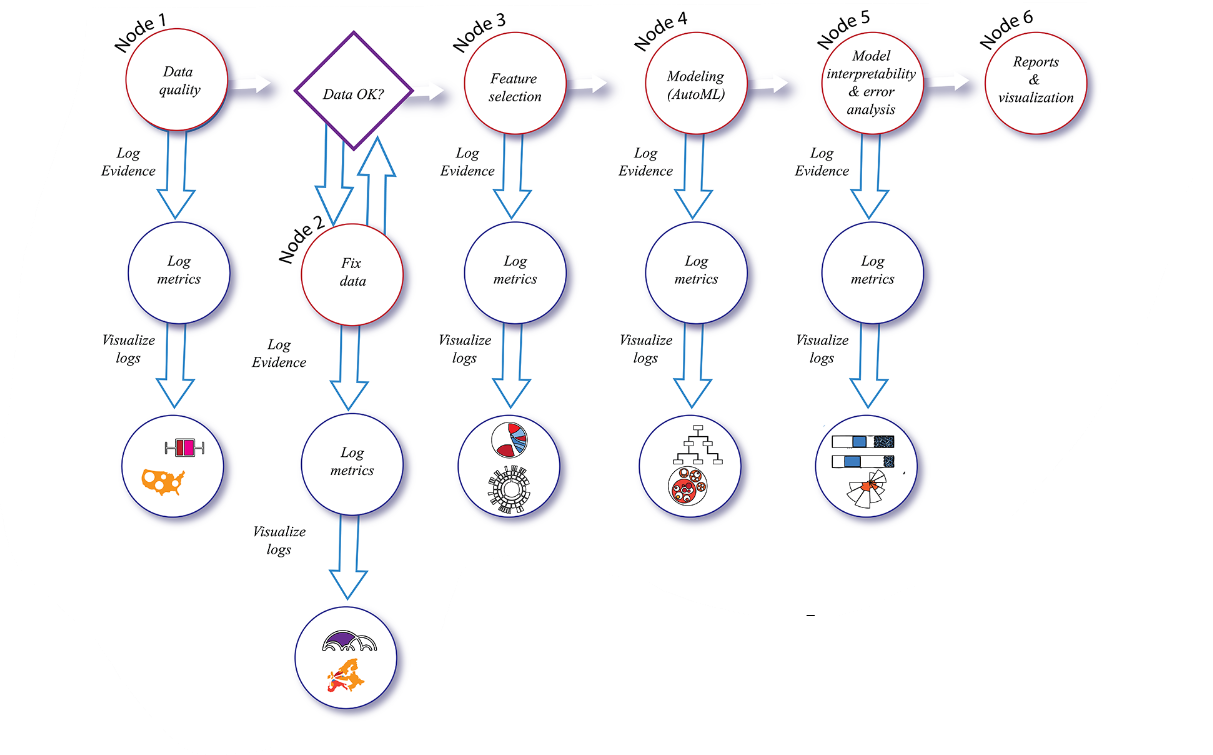

#Node 1: Data Quality

_________________________________________________________
###Getting our data

This dataset contains 51717 data values which is above GitHub's threshold of .csv files. Accordingly, we pull in the kaggle dataset directly using the kaggle library and my kaggle credentials.

In [1]:
#installing dependencies
!pip install eli5
!pip install shap
! pip install -q kaggle
#installing h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 10.6 MB/s 
     |████████████████████████████████| 133 kB 30.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=6670006a44f42ca450e764063257f4d29a7b8f1dd7981de6890270b71aa4d615
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incomp

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
#importing all necessary libraries
%matplotlib inline  
import random, os, sys
import h2o
import pprint
import operator
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import math
import shap

In [3]:
#making a directory for kaggle api
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
#downloading and reading the zomato dataset
! kaggle datasets list -s zomato # searching through kaggle with keyword 'zomato'
! kaggle datasets download -d pranavuikey/zomato-eda
!unzip zomato-eda.zip

ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
himanshupoddar/zomato-bangalore-restaurants                  Zomato Bangalore Restaurants                        89MB  2019-03-31 09:48:43          47918       1181  1.0              
shrutimehta/zomato-restaurants-data                          Zomato Restaurants Data                              5MB  2018-03-13 04:56:25          45833        626  0.7941176        
rishikeshkonapure/zomato                                     Zomato                                              89MB  2022-10-29 06:56:33           1682         49  1.0              
batjoker/zomato-restaurants-hyderabad                        Zomato Restaurants 

In [5]:
#Viewing data in the file 
data = pd.read_csv("zomato.csv")
data.shape
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


Additionally, I have sampled a 2000 random points as an alternative for a local file and commented out the code to change the input to that file

In [6]:
#data = pd.read_csv('zomatoSample.csv')

#Node 2: Fix data

##Cleaning Up Data


The dataset contains inconsistant values and missing data so it will require cleaning up. The significance of the predictors is investigated and it appears that of the 16 independent variables,  9 are significant, these results can be used to further optimize the model for predicting the best restaurants depending on a customer's need. Additionally, we must clean the dataset for this assignment to prevent any errors that would limit the full potential of AutoML.

###Dropping columns 

The columns phone, dish_liked, url, menu_item, and reviews_list help identify the restaurant but do not add characteristics to the dataset so we can drop them. 

In [7]:
data.drop(['url','address','phone','menu_item','dish_liked','reviews_list',"listed_in(city)"],axis = 1,inplace=True)
data.head(3)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type)
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet


#### Renaming Column Headers
To better understand the data, let's first rename our column headers with appropriate units and descripter language. 

In [8]:
data.rename(columns={'name':'Restaurant','online_order': 'Online Ordering?', 'book_table':'Reservation Needed?','votes': 'Number of Votes','location':'City','rest_type': 'Restaurant Type', 'cuisines': 'Cuisines','rate':'Rating','approx_cost(for two people)':'Cost(Rupees)','listed_in(type)':'Meal Type'},inplace=True)
data.head(3)

,Restaurant,Online Ordering?,Reservation Needed?,Rating,Number of Votes,City,Restaurant Type,Cuisines,Cost(Rupees),Meal Type
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet


###Missing Data

Imputing Missing Data:
We have three methods for imputing missing data. Using the median, dropping, and using machine learning. 

In [9]:
missing_list = data.columns[data.isna().any()].tolist() 
missing_count = []      
for i in missing_list:
  missing_count.append(sum(pd.isnull(data[str(i)])))

d = {'Missing_Column':missing_list,'Missing_Values':missing_count}
Missing_DF = pd.DataFrame(d)
Missing_DF["%_Missing"] = (Missing_DF['Missing_Values'] / data.shape[0]) * 100
Missing_DF

,Missing_Column,Missing_Values,%_Missing
0,Rating,7775,15.033741
1,City,21,0.040606
2,Restaurant Type,227,0.438927
3,Cuisines,45,0.087012
4,Cost(Rupees),346,0.669026


We see that most of our missing data is Rating. The median method in this case would not make sense for null values because rating for a restaurant should not be effected by the rest of the data. For example, a new restaurant that did not get the chance pass the inspection exam with rating "NEW" should not be replaced by a 3 star rating when there is an equal chance the restaurant could be of lower or higher quality. We could potentially explore Machine Learning but for the purposes of the training data we can justify using the dropping method for columns that are missing 5% or less of data since it is a very small percentage of missing data.
Note: I chose to drop NaN but other notebooks chose to use the mean to replace empty values.

In [10]:
data = data.dropna()
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30958 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Restaurant           30958 non-null  object
 1   Online Ordering?     30958 non-null  object
 2   Reservation Needed?  30958 non-null  object
 3   Rating               30958 non-null  object
 4   Number of Votes      30958 non-null  int64 
 5   City                 30958 non-null  object
 6   Restaurant Type      30958 non-null  object
 7   Cuisines             30958 non-null  object
 8   Cost(Rupees)         30958 non-null  object
 9   Meal Type            30958 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.6+ MB


In [11]:
data.isnull().sum()

Restaurant             0
Online Ordering?       0
Reservation Needed?    0
Rating                 0
Number of Votes        0
City                   0
Restaurant Type        0
Cuisines               0
Cost(Rupees)           0
Meal Type              0
dtype: int64

#### Remove Duplicates
In case we have any duplicated rows, we remove duplicates. This is ensure there is no bias with repeating restaurants.

In [12]:
data.drop_duplicates(inplace=True)
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30958 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Restaurant           30958 non-null  object
 1   Online Ordering?     30958 non-null  object
 2   Reservation Needed?  30958 non-null  object
 3   Rating               30958 non-null  object
 4   Number of Votes      30958 non-null  int64 
 5   City                 30958 non-null  object
 6   Restaurant Type      30958 non-null  object
 7   Cuisines             30958 non-null  object
 8   Cost(Rupees)         30958 non-null  object
 9   Meal Type            30958 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.6+ MB


### Clean up individual columns
Finally, we should check each variable and clean out data that does not make sense. This can either mean standardizing what "null" means in that context or removing random characters from changing data formats from object to integer



##### *Rating*

In [13]:
data['Rating'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

By displaying all unique values from the Rating column, we see that some entries contain "NEW", "nan", and "-" representing no ratings. We can standardize empty values to be nan. We also see that the Rating field contains strings of a floating number out of 5. To prepare for analyzing our data, we will extract the rating, setting the variable to be of type float. 

In [14]:
def clean(value):
    if value=='NEW' or value=='-':
        return np.nan
    else:
        value=str(value).split('/')
        value=value[0]
        return float(value)
    
data['Rating']=data['Rating'].apply(clean)
data['Rating'].head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30958 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Restaurant           30958 non-null  object 
 1   Online Ordering?     30958 non-null  object 
 2   Reservation Needed?  30958 non-null  object 
 3   Rating               29638 non-null  float64
 4   Number of Votes      30958 non-null  int64  
 5   City                 30958 non-null  object 
 6   Restaurant Type      30958 non-null  object 
 7   Cuisines             30958 non-null  object 
 8   Cost(Rupees)         30958 non-null  object 
 9   Meal Type            30958 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 2.6+ MB


In [15]:
data = data.dropna(subset=["Rating"])
data['Rating'] = [round(x) for x in data['Rating']]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
data['Rating'].unique()

array([4, 5, 3, 2])

##### *Location*


In [17]:
data['City'].unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Bannerghatta Road', 'BTM', 'Kanakapura Road', 'Bommanahalli',
       'Electronic City', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Richmond Road', 'HSR',
       'Koramangala 7th Block', 'Bellandur', 'Sarjapur Road',
       'Marathahalli', 'Whitefield', 'East Bangalore', 'Old Airport Road',
       'Indiranagar', 'Koramangala 1st Block', 'Frazer Town', 'MG Road',
       'Brigade Road', 'Lavelle Road', 'Church Street', 'Ulsoor',
       'Residency Road', 'Shivajinagar', 'Infantry Road',
       'St. Marks Road', 'Cunningham Road', 'Race Course Road',
       'Commercial Street', 'Vasanth Nagar', 'Domlur',
       'Koramangala 8th Block', 'Ejipura', 'Jeevan Bhima Nagar',
       'Old Madras Road', 'Seshadripuram', 'Kammanahalli',
       'Koramangala 6th Block', 'Ma

In [18]:
data['City'].value_counts(ascending=False)

BTM                      2100
Indiranagar              1583
Koramangala 5th Block    1554
Whitefield               1537
HSR                      1480
                         ... 
Yelahanka                   4
West Bangalore              3
Rajarajeshwari Nagar        2
Nagarbhavi                  1
Peenya                      1
Name: City, Length: 92, dtype: int64

Looking at the breakdown of cities we see no typos or errors and can proceed.

##### *Cost*


In [19]:
data['Cost(Rupees)'].unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1,200', '350', '250',
       '950', '1,000', '1,500', '1,300', '199', '1,100', '1,600', '230',
       '130', '1,700', '1,350', '2,200', '1,400', '2,000', '1,800',
       '1,900', '180', '330', '2,500', '2,100', '3,000', '2,800', '3,400',
       '50', '40', '1,250', '3,500', '4,000', '2,400', '2,600', '1,450',
       '70', '3,200', '240', '6,000', '1,050', '2,300', '4,100', '120',
       '5,000', '3,700', '1,650', '2,700', '4,500', '80'], dtype=object)

Examining the unique values of Cost, we can see that the cost is stored as text with type object. We can correct the type to integer so that we can later model the variables.





In [20]:
data = data.dropna()

In [21]:
def money(value):
    value=str(value)
    if ',' in value:
        value=value.replace(',','')
        return int(value)
    else:
        return int(value)

data['Cost(Rupees)']=data['Cost(Rupees)'].apply(money)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29638 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Restaurant           29638 non-null  object
 1   Online Ordering?     29638 non-null  object
 2   Reservation Needed?  29638 non-null  object
 3   Rating               29638 non-null  int64 
 4   Number of Votes      29638 non-null  int64 
 5   City                 29638 non-null  object
 6   Restaurant Type      29638 non-null  object
 7   Cuisines             29638 non-null  object
 8   Cost(Rupees)         29638 non-null  int64 
 9   Meal Type            29638 non-null  object
dtypes: int64(3), object(7)
memory usage: 2.5+ MB


##### *Booking*


In [23]:
data['Reservation Needed?'].unique()

array(['Yes', 'No'], dtype=object)

Booking has no typos so we can proceed.

##### *Online Order*


In [24]:
data['Online Ordering?'].unique()

array(['Yes', 'No'], dtype=object)

Online Ordering has no typos so we can proceed.

##### *Restaurant Type*


In [25]:
data['Restaurant Type'].unique()

array(['Casual Dining', 'Cafe, Casual Dining', 'Quick Bites',
       'Casual Dining, Cafe', 'Cafe', 'Quick Bites, Cafe',
       'Cafe, Quick Bites', 'Delivery', 'Mess', 'Dessert Parlor',
       'Bakery, Dessert Parlor', 'Pub', 'Bakery', 'Takeaway, Delivery',
       'Fine Dining', 'Beverage Shop', 'Sweet Shop', 'Bar',
       'Dessert Parlor, Sweet Shop', 'Bakery, Quick Bites',
       'Sweet Shop, Quick Bites', 'Kiosk', 'Food Truck',
       'Quick Bites, Dessert Parlor', 'Beverage Shop, Quick Bites',
       'Beverage Shop, Dessert Parlor', 'Takeaway', 'Pub, Casual Dining',
       'Casual Dining, Bar', 'Dessert Parlor, Beverage Shop',
       'Quick Bites, Bakery', 'Microbrewery, Casual Dining', 'Lounge',
       'Bar, Casual Dining', 'Food Court', 'Cafe, Bakery', 'Dhaba',
       'Quick Bites, Sweet Shop', 'Microbrewery',
       'Food Court, Quick Bites', 'Quick Bites, Beverage Shop',
       'Pub, Bar', 'Casual Dining, Pub', 'Lounge, Bar',
       'Dessert Parlor, Quick Bites', 'Food Court, 

In [26]:
data['Restaurant Type'].value_counts(ascending=False)

Quick Bites                   9492
Casual Dining                 7151
Cafe                          2420
Dessert Parlor                1309
Delivery                      1054
                              ... 
Bakery, Food Court               2
Food Court, Beverage Shop        2
Bakery, Beverage Shop            1
Quick Bites, Kiosk               1
Dessert Parlor, Food Court       1
Name: Restaurant Type, Length: 87, dtype: int64

The Restaurant type has lots of values with multiple values for one restaurant. We can simplify the types to general group for better analysis.

In [27]:
def typeSimplify(value):
    value = str(value)
    if 'Sweet' in value or 'Dessert' in value or 'Confectionery' in value:
        return 'Dessert'
    elif 'Quick Bites' in value:
      return 'Quick Bites'
    elif 'Bar' in value or 'Microbrewery' in value:
      return 'Bar'
    elif 'Bakery' in value:
      return 'Bakery'
    elif 'Casual Dining' in value:
      return 'Casual Dining'
    elif 'Fine Dining' in value:
      return 'Fine Dining'
    elif 'Food Court' in value:
      return 'Street Food'
    elif 'Fast Food' in value:
      return 'Fast Food'
    elif 'Cafe' in value:
      return 'Cafe'
    elif 'North Indian' in value:
      return 'North Indian'
    elif 'South Indian' in value:
      return 'South Indian'
    else:
        return value
    
data['Restaurant Type']=data['Restaurant Type'].apply(typeSimplify)
data['Restaurant Type'].head(10)

0    Casual Dining
1    Casual Dining
2    Casual Dining
3      Quick Bites
4    Casual Dining
5    Casual Dining
6    Casual Dining
7    Casual Dining
8             Cafe
9             Cafe
Name: Restaurant Type, dtype: object

In [28]:
data['Restaurant Type'].unique()

array(['Casual Dining', 'Quick Bites', 'Cafe', 'Delivery', 'Mess',
       'Dessert', 'Pub', 'Bakery', 'Takeaway, Delivery', 'Fine Dining',
       'Beverage Shop', 'Bar', 'Kiosk', 'Food Truck', 'Takeaway',
       'Lounge', 'Street Food', 'Dhaba', 'Club', 'Bhojanalya'],
      dtype=object)

In [29]:
data['Restaurant Type'].isnull().sum()

0

##### *Meal Type*


In [30]:
data['Meal Type'].unique()

array(['Buffet', 'Cafes', 'Delivery', 'Desserts', 'Dine-out',
       'Drinks & nightlife', 'Pubs and bars'], dtype=object)

In [31]:
data['Meal Type'].value_counts()

Delivery              13504
Dine-out              10867
Desserts               2031
Cafes                  1136
Drinks & nightlife      877
Buffet                  655
Pubs and bars           568
Name: Meal Type, dtype: int64

Meal Type has no typos so we can proceed.

##### *Cuisines*


In [32]:
data['Cuisines'].unique()

array(['North Indian, Mughlai, Chinese', 'Chinese, North Indian, Thai',
       'Cafe, Mexican, Italian', ..., 'Tibetan, Nepalese',
       'North Indian, Street Food, Biryani',
       'North Indian, Chinese, Arabian, Momos'], dtype=object)

In [33]:
data['Cuisines'].value_counts()

North Indian                                1518
North Indian, Chinese                       1339
South Indian                                 851
Bakery, Desserts                             455
Biryani                                      410
                                            ... 
South Indian, Mangalorean, Chinese             1
Fast Food, Andhra                              1
Kerala, Biryani, North Indian, Chettinad       1
North Indian, Street Food, Fast Food           1
North Indian, Chinese, Arabian, Momos          1
Name: Cuisines, Length: 2367, dtype: int64

Cuisines have multiple values for one restaurant with repeating keywords but they show has different categories. We can simplify this to general groups for better analysis. 

In [34]:
data['Cuisines'].isnull().sum()

0

In [35]:
def cuisineSimplify(value):
    value = str(value)
    if 'Italian' in value or 'Pizza' in value:
        return 'Italian'
    elif 'African' in value:
      return 'African'
    elif 'Continental' in value:
      return 'Continental'
    elif "Mughlai" in value or 'Middle Eastern' in value or 'Biryani' in value or 'Arabian' in value or 'Turkish' in value:
      return 'Middle Eastern'
    elif 'Burger' in value or 'American' in value or 'Salad' in value or 'Sandwich' in value:
      return 'American'
    elif 'Indian' in value and 'Chinese' in value:
      return 'Asian Fusion'
    elif 'Thai' in value or 'Japanese' in value or 'Asian' in value or 'Chinese' in value or 'Tibetan' in value or 'Momo' in value:
      return 'Asian'
    elif 'Mexican' in value:
      return 'Mexican'
    elif 'Street Food' in value:
      return 'Street Food'
    elif 'Fast Food' in value:
      return 'Fast Food'
    elif 'Cafe' in value:
      return 'Cafe'
    elif 'North Indian' in value or 'Rajasthani' in value or "Gujarati" in value or 'Bengali' in value:
      return 'North Indian'
    elif 'South Indian' in value or 'Kerala' in value or 'Bengali' in value or 'Andhra' in value or 'Maharashtrian':
      return 'South Indian'
    elif 'Mediterranean' in value:
      return 'Mediterranean'
    elif 'Sweet' in value or 'Dessert' in value or 'Confectionery' in value or 'Mithai' in value:
      return 'Dessert'
    elif 'Cafe' in value:
      return 'Cafe'
    else:
        return value
    
data['Cuisines']=data['Cuisines'].apply(cuisineSimplify)
data['Cuisines'].head(10)


0    Middle Eastern
1      Asian Fusion
2           Italian
3      North Indian
4      North Indian
5      North Indian
6      Asian Fusion
7           Italian
8           Italian
9           Italian
Name: Cuisines, dtype: object

In [36]:
data['Cuisines'].unique()

array(['Middle Eastern', 'Asian Fusion', 'Italian', 'North Indian',
       'Cafe', 'Continental', 'Fast Food', 'American', 'South Indian',
       'Asian', 'Street Food', 'African', 'Mexican'], dtype=object)

##### *Restaurant*

In [37]:
data.drop(['Restaurant'],axis = 1,inplace=True)

##### *Number of Votes*

In [38]:
data = data.dropna(subset=['Number of Votes'])

In [39]:
data['Number of Votes'].unique()

array([ 775,  787,  918, ..., 4957, 2382,  843])

In [40]:
ALOT = 1e6
data['Number of Votes'] = [max(min(x, ALOT), -ALOT) for x in data['Number of Votes']]

#Node 3: Feature Selection

During feature selection, we will check the quality of the data and determine which features are important. We will use statistical methods like p-value, t-statistics and visualization techniques like histogram, Q-Q plot, scatter plot, box-plot of python's matplotlib and seaborn library to answer below questions about the dataset:
* Which independent variables are useful to predict a target (dependent variable)?
* Which independent variables have missing data? How much
* Do the training and test sets have the same data?
* In the predictor variables independent of all the other predictor variables?
* Which predictor variables are the most important?
* Do the ranges of the predictor variables make sense?
* What are the distributions of the predictor variables?

##Data transforming

Now that our dataset is cleaned up, let us standardize the data to compare data in the same unit set. Standardizing data is good practice to define how data should be formatted, eliminating extraneous data, and identifying data errors/multicollinearity. In this assignment, we encode the categorical features and impute the numerical features.

In [41]:
data = data.dropna()

In [42]:
data.replace([np.inf, -np.inf], 0, inplace=True)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29638 entries, 0 to 51716
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Online Ordering?     29638 non-null  object
 1   Reservation Needed?  29638 non-null  object
 2   Rating               29638 non-null  int64 
 3   Number of Votes      29638 non-null  int64 
 4   City                 29638 non-null  object
 5   Restaurant Type      29638 non-null  object
 6   Cuisines             29638 non-null  object
 7   Cost(Rupees)         29638 non-null  int64 
 8   Meal Type            29638 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.3+ MB


In [44]:
data_clean = data #making a copy so we don't lose all that progress!

In [45]:
data_clean['Reservation Needed?'] = data_clean['Reservation Needed?'].map({'Yes': 1, 'No': 0})

We can convert our catagorical variables to numerical ones by creating a new column for each group with a binary value of 1 if that value belongs to that entry (0 if not).

In [46]:
data_clean['Online Ordering?'] = data_clean['Online Ordering?'].map({'Yes': 1, 'No': 0})

In [47]:
from sklearn.model_selection import  train_test_split
import statsmodels.api as sm

X = data_clean.drop(['Rating'],axis=1)
Y = data_clean['Rating']

catagorical_features = ['City', 'Restaurant Type', 'Cuisines', 'Meal Type']
numerical_features = [c for c in X.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

data_clean = data_clean.dropna(subset=['Rating'])

#Spliting data into Training 76.5%, Validation set 13.5% and Test set 10%
X_t, X_test, y_t, y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

preprocessed_lin_X_train = mapper.fit_transform(X_train)
preprocessed_lin_X_train = sm.add_constant(preprocessed_lin_X_train)


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


##Feature Analysis

Based on the QQ Plots for the numeric variables, we see that the data is skewed and non-linear. We can predict that in AutoML, we are less likely to see linear models.

invalid value encountered in true_divide


<Figure size 576x360 with 0 Axes>

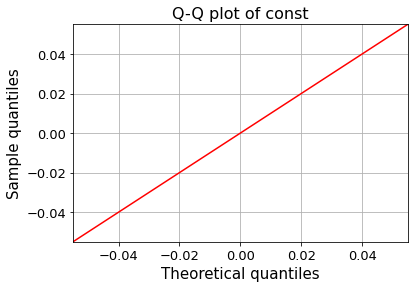

<Figure size 576x360 with 0 Axes>

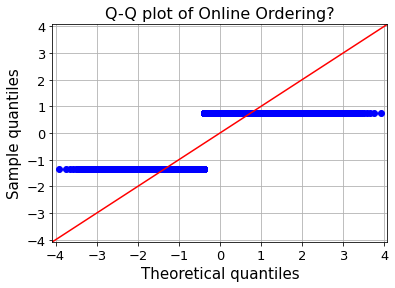

<Figure size 576x360 with 0 Axes>

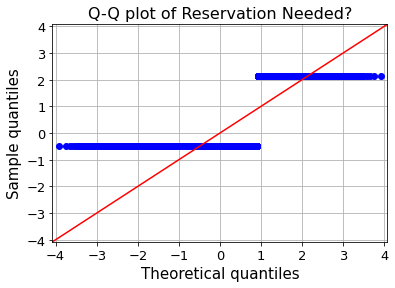

<Figure size 576x360 with 0 Axes>

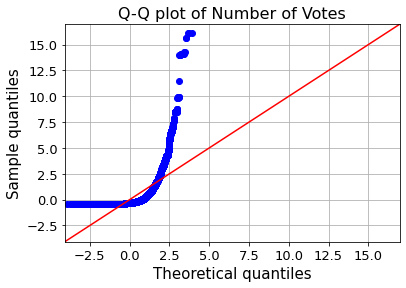

<Figure size 576x360 with 0 Axes>

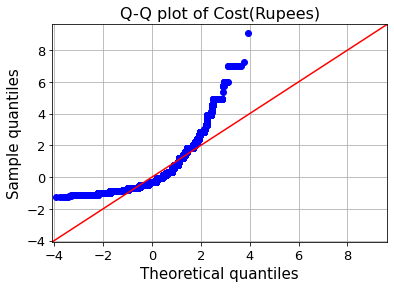

<Figure size 576x360 with 0 Axes>

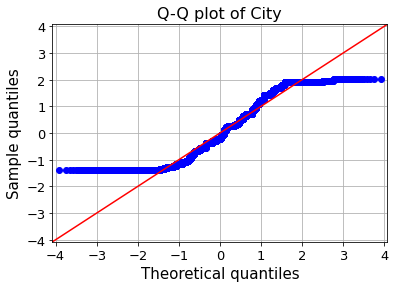

<Figure size 576x360 with 0 Axes>

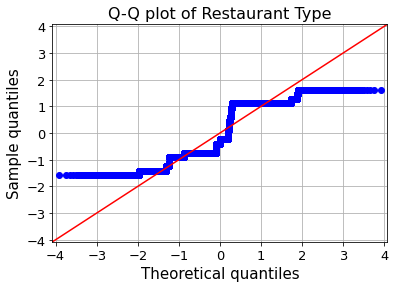

<Figure size 576x360 with 0 Axes>

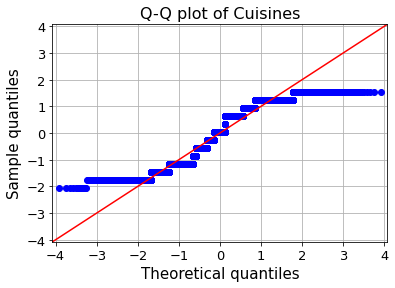

<Figure size 576x360 with 0 Axes>

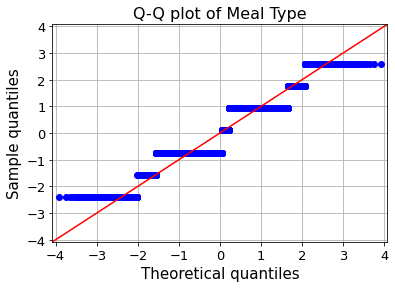

In [48]:
#checking the distribution of independent variables
from statsmodels.graphics.gofplots import qqplot
data_temp=preprocessed_lin_X_train
for c in data_temp.columns[:]:
  plt.figure(figsize=(8,5))
  fig=qqplot(data_temp[c],line='45',fit='True')
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.xlabel("Theoretical quantiles",fontsize=15)
  plt.ylabel("Sample quantiles",fontsize=15)
  plt.title("Q-Q plot of {}".format(c),fontsize=16)
  plt.grid(True)
  plt.show()

In [49]:
print("Skewness of Votes: %f" % preprocessed_lin_X_train['Number of Votes'].skew())
print("Kurtosis of Votes: %f" % preprocessed_lin_X_train['Number of Votes'].kurt())
print("Skewness of Cost: %f" % preprocessed_lin_X_train['Cost(Rupees)'].skew())
print("Kurtosis of Cost: %f" % preprocessed_lin_X_train['Cost(Rupees)'].kurt())

Skewness of Votes: 6.248328
Kurtosis of Votes: 59.849961
Skewness of Cost: 2.190684
Kurtosis of Cost: 7.056706


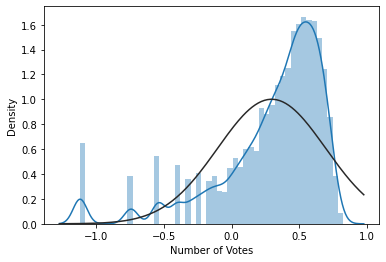

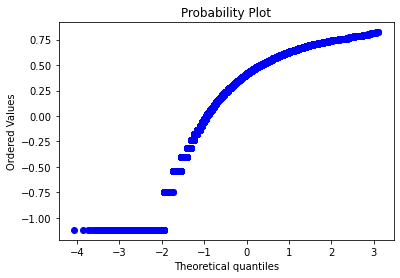

In [52]:
from scipy.stats import norm
from scipy import stats
#log transformation RUN THIS TWICE
data_clean['Number of Votes'] = np.log(data_clean['Number of Votes'])

#transformed histogram and normal probability plot
sns.distplot(data_clean['Number of Votes'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_clean['Number of Votes'], plot=plt)

By applying a log transformation, we can see the mean (center) of the dataset shift to the left with a thicker distribution. Followed by the probability plot which shows us a better linear line. *Phew*

We can do the same thing with the Cost variable.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


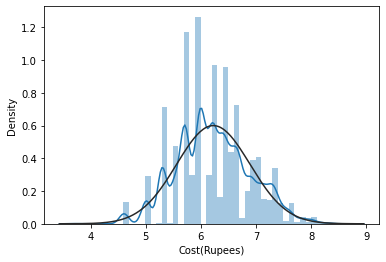

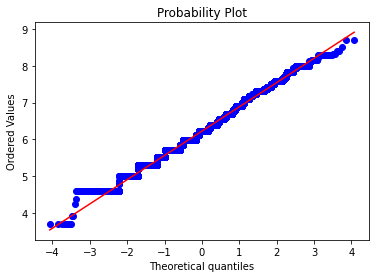

In [53]:
#data transformation
data_clean['Cost(Rupees)'] = np.log(data_clean['Cost(Rupees)'])

#transformed histogram and normal probability plot
sns.distplot(data_clean['Cost(Rupees)'], fit=norm);
fig = plt.figure()
res = stats.probplot(data_clean['Cost(Rupees)'], plot=plt)

The distribution plot produced a normal distribution and the probability plot follows a diagonal line. We can now proceed to analyze our numerical data. 

In [54]:
preprocessed_lin_X_train.corr()

,const,Online Ordering?,Reservation Needed?,Number of Votes,Cost(Rupees),City,Restaurant Type,Cuisines,Meal Type
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Online Ordering?,NaN,1.000000,-0.064243,-0.023610,-0.179617,-0.064831,0.059532,-0.000316,-0.213552
Reservation Needed?,NaN,-0.064243,1.000000,0.387332,0.628329,0.082529,-0.368943,-0.077601,0.116343
Number of Votes,NaN,-0.023610,0.387332,1.000000,0.383551,0.044497,-0.259863,-0.087119,0.067351
Cost(Rupees),NaN,-0.179617,0.628329,0.383551,1.000000,0.157636,-0.448328,-0.173834,0.183317
City,NaN,-0.064831,0.082529,0.044497,0.157636,1.000000,-0.066970,-0.002402,0.032379
Restaurant Type,NaN,0.059532,-0.368943,-0.259863,-0.448328,-0.066970,1.000000,0.044433,-0.027679
Cuisines,NaN,-0.000316,-0.077601,-0.087119,-0.173834,-0.002402,0.044433,1.000000,-0.030323
Meal Type,NaN,-0.213552,0.116343,0.067351,0.183317,0.032379,-0.027679,-0.030323,1.000000


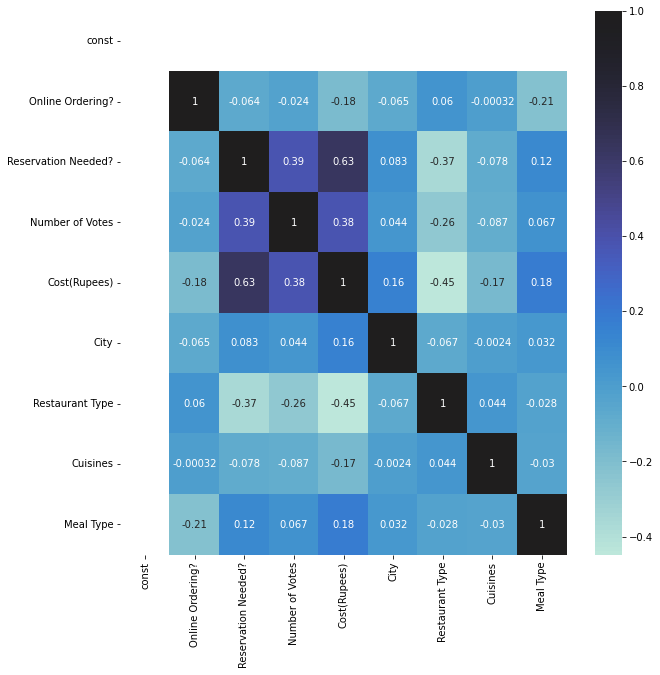

In [55]:
plt.figure(figsize = (10, 10))
corr=preprocessed_lin_X_train.corr()
sns.heatmap(corr, annot = True, center=1)
plt.show()

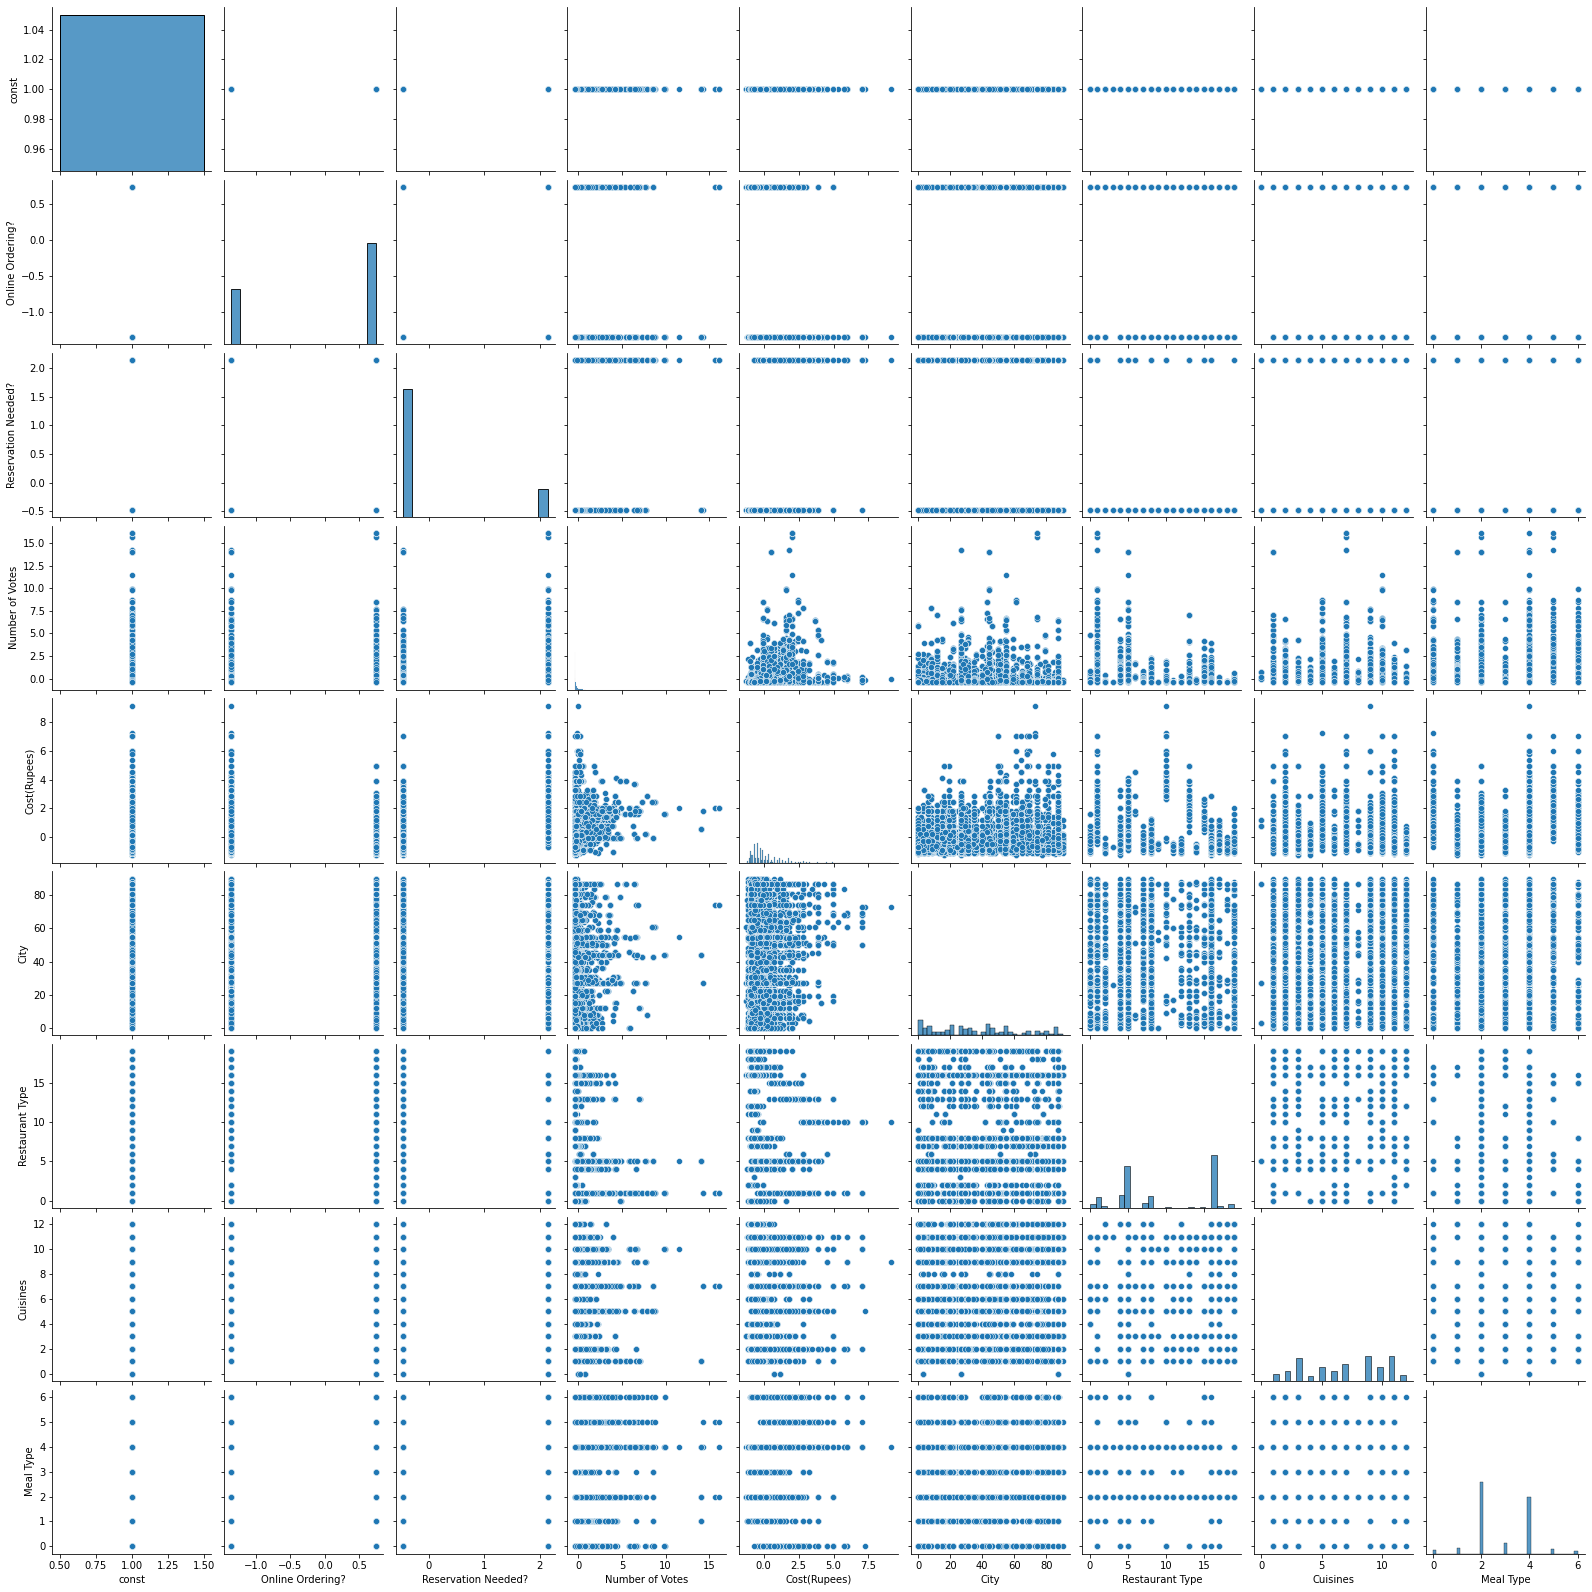

In [56]:
sns.pairplot(preprocessed_lin_X_train)

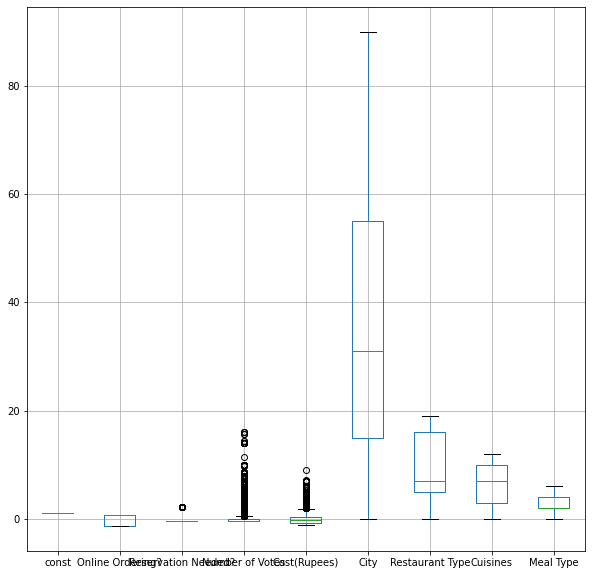

In [57]:
plt.figure(figsize=(10,10))
preprocessed_lin_X_train.boxplot()

**Is the relationship significant?**

In [58]:
#Using OLS for finding the p value to check the significant features
from sklearn import datasets, linear_model

model = sm.OLS(y_train, preprocessed_lin_X_train, axis =1).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     518.5
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:50:22   Log-Likelihood:                -13894.
No. Observations:               22672   AIC:                         2.781e+04
Df Residuals:                   22663   BIC:                         2.788e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.8110      0.012    316.844      0.000       3.787       3.835
Online Ordering?        0.0541      0.003     17.539      0.000       0.048       0.060
Reservation Needed?     0.0489      0.004     12.450      0.000       0.041       0.057
Number of Votes         0.1054      0.003     31.976      0.000       0.099       0.112
Cost(Rupees)            0.0584      0.004     13.794      0.000       0.050       0.067
City                -5.055e-05      0.000     -0.442      0.659      -0.000       0.000
Restaurant Type        -0.0065      0.001    -11.446      0.000      -0.008      -0.005
Cuisines                0.0038      0.001      4.215      0.000       0.002       0.006
Meal Type              -0.0064      0.003     -2.504      0.012      -0.011      -0.001
==============================================================================
Omnibus:                     2048.850   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2647.042
Skew:                          -0.827   Prob(JB):                         0.00
Kurtosis:                       3.256   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the low p-value and high t-statistic for a majority of the data, we can say that the relationship between rating and the number of votes,cost, and need for reservation is significant in addition to other categorical variables. We will further drill down which fields are exactly useful in predicing ratings in a cleaner way with AutoML



Taking a look at our coefficients, we see that all features are significant except for City with a t-score lower than the p-value and the confident interval overlapping 0. We also see a y-intercept of 3.811 meaning that restaurants will typically be rated with 3.811 stars when all other factors are 0 or none. Additionally, Number of Votes shows the biggest positive influence on Ratings and Cuisine showing least influence on Ratings. Restaurant Type and Meal Type can slightly negatively impact a restaurant's ratings while the presence of Online Ordering, Reservations Needed, Number of Votes, Cost, and Cuisines have a postive impact on Rating.

**In the multivariate models are predictor variables independent of all the other predictor variables? Is there any multicollinearity in the model?**

In [59]:
#Compute VIF data for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = preprocessed_lin_X_train.columns
vif["vif_Factor"] = [variance_inflation_factor(preprocessed_lin_X_train.values, i) for i in range(preprocessed_lin_X_train.shape[1])]
vif.head(10)

,features,vif_Factor
0,const,16.439729
1,Online Ordering?,1.079364
2,Reservation Needed?,1.753220
3,Number of Votes,1.235039
4,Cost(Rupees),2.036943
5,City,1.028115
6,Restaurant Type,1.287198
7,Cuisines,1.037189
8,Meal Type,1.076453


It is usually considered to be highly correlated if the VIF value is higher than 5. None of the values we were looking at show a VIF value of 5 so we can assume there is no multicollinearly. A large vif in the constant indicates that the (slope) explanatory variables have also a large constant component. An example would be when a variable has a large mean but only a small variance. 

##Outliers

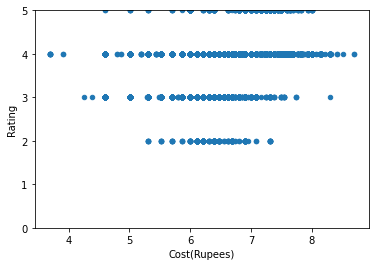

In [60]:
#bivariate analysis Rating/Cost
var = 'Cost(Rupees)'
data = pd.concat([data_clean['Rating'], data_clean[var]], axis=1)
data.plot.scatter(x=var, y='Rating', ylim=(0,5));

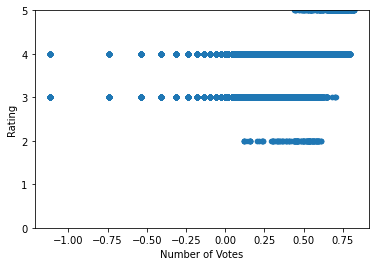

In [61]:
#bivariate analysis Rating/Cost
var = 'Number of Votes'
data = pd.concat([data_clean['Rating'], data_clean[var]], axis=1)
data.plot.scatter(x=var, y='Rating', ylim=(0,5));

Plotting the two numerical variables against the standardized Rating, we do not see any outliers.

From the analysis done above on the dataset, we see that the dataset has no multicollinearity and that all features except for City are significant to predict ratings for restaurants. We can see that our data is right skewed and as we can predict a linear model will not be the best model for this dataset.

#Node 4: Modeling (AutoML)

The aim of this node is to create predictive models in AutoML, find the best model to predict restaurant ratings, and interpret each model. We will explore:
* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

##Initializing H2O


We must first install H2O and start the software.

In [62]:
min_mem_size=6 
run_time=333

In [63]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [64]:
h2o.init(strict_version_check=False) # start h2o

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp99e0fq9q
  JVM stdout: /tmp/tmp99e0fq9q/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp99e0fq9q/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_jeoc8j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [65]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [66]:
#Viewing data 
data = h2o.H2OFrame(data_clean)
data.shape
data.describe()
data.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:29638
Cols:9

,Online Ordering?,Reservation Needed?,Rating,Number of Votes,City,Restaurant Type,Cuisines,Cost(Rupees),Meal Type
type,int,int,int,real,enum,enum,enum,real,enum
mins,0.0,0.0,2.0,-1.1189142050548058,,,,3.688879454113936,
mean,0.648019434509751,0.17929684864025913,3.7513664889668608,0.2946173914446606,,,,6.2252422697062695,
maxs,1.0,1.0,5.0,0.8221209128056116,,,,8.699514748210191,
sigma,0.4775960041068574,0.3836071607362359,0.48789440532137324,0.39858385957719494,,,,0.664828770983508,
zeros,10432,24324,0,0,,,,0,
missing,0,0,0,27,0,0,0,0,0
0,1.0,1.0,4.0,0.6392437948170829,Banashankari,Casual Dining,Middle Eastern,6.684611727667927,Buffet
1,1.0,0.0,4.0,0.6404603866075681,Banashankari,Casual Dining,Asian Fusion,6.684611727667927,Buffet
2,1.0,0.0,4.0,0.6524197742738553,Banashankari,Casual Dining,Italian,6.684611727667927,Buffet


Online Ordering?,Reservation Needed?,Rating,Number of Votes,City,Restaurant Type,Cuisines,Cost(Rupees),Meal Type
1,1,4,0.639244,Banashankari,Casual Dining,Middle Eastern,6.68461,Buffet
1,0,4,0.64046,Banashankari,Casual Dining,Asian Fusion,6.68461,Buffet
1,0,4,0.65242,Banashankari,Casual Dining,Italian,6.68461,Buffet
0,0,4,0.404817,Banashankari,Quick Bites,North Indian,5.70378,Buffet
0,0,4,0.489554,Basavanagudi,Casual Dining,North Indian,6.39693,Buffet
1,0,4,0.54969,Basavanagudi,Casual Dining,North Indian,6.39693,Buffet
0,0,4,-0.311839,Mysore Road,Casual Dining,Asian Fusion,6.68461,Buffet
1,1,5,0.72272,Banashankari,Casual Dining,Italian,6.39693,Cafes
1,0,4,0.562202,Banashankari,Cafe,Italian,6.55108,Cafes
1,0,4,0.603323,Banashankari,Cafe,Italian,6.30992,Cafes


##Predicting Rating

Now that we have initialized H2O with the zomato dataset, we should split the values into training and test datasets for verification.

In [107]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

In [108]:
# assign target and inputs for logistic regression
y = 'Rating'
X = [name for name in train.columns if name != y]
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
print(y)
print(X)

Rating
['Online Ordering?', 'Reservation Needed?', 'Number of Votes', 'City', 'Restaurant Type', 'Cuisines', 'Cost(Rupees)', 'Meal Type']


In [109]:
aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

Using AutoML, pass in training and testing datasets as well as the predictor values to predict Rating.

In [110]:
aml.train(x=X,y=y,training_frame=train, validation_frame=test)  # Change training_frame=train

AutoML progress: |
01:04:16.523: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████
01:05:51.203: GLM_1_AutoML_2_20221216_10416 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException

████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_2_20221216_10416


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    161                644                         1.28172e+06            15           15           14.5202       1             141           118.981

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.026728829325791226
RMSE: 0.16348953888793993
LogLoss: 0.10955494801339972
Mean Per-Class Error: 0.025896122827936262
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4      5    Error      Rate
---  ----  -----  ---  ---------  ------------
156  0     0      0    0          0 / 156
2    5263  378    0    0.0673401  380 / 5,643
1    197   15890  3    0.0124915  201 / 16,091
0    0     10     411  0.023753   10 / 421
159  5460  16278  414  0.0264892  591 / 22,311

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.973511
2    0.999955
3    1
4    1

ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.06901130739348776
RMSE: 0.26270003310522777
LogLoss: 0.24049463000914667
Mean Per-Class Error: 0.15831080499329397
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4     5    Error      Rate
---  ----  ----  ---  ---------  -----------
37   6     7     0    0.26       13 / 50
3    1481  383   0    0.206749   386 / 1,867
1    234   5039  4    0.0452823  239 / 5,278
0    0     16    116  0.121212   16 / 132
41   1721  5445  120  0.0892589  654 / 7,327

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.910741
2    0.997543
3    0.999591
4    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07698554228844741
RMSE: 0.2774626862993426
LogLoss: 0.27150733089738527
Mean Per-Class Error: 0.20434626659901578
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4      5    Error      Rate
---  ----  -----  ---  ---------  --------------
97   14    45     0    0.378205   59 / 156
7    4289  1347   0    0.239943   1,354 / 5,643
4    776   15293  18   0.0495929  798 / 16,091
0    0     63     358  0.149644   63 / 421
108  5079  16748  376  0.101923   2,274 / 22,311

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.898077
2    0.996997
3    0.999641
4    1

Cross-Validation Metrics Summary: 
                         mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.897853   0.00606119  0.901188      0.895563      0.897355      0.889511      0.905648

In [71]:
print(aml.get_leaderboard().head(20))

model_id                                                  mean_per_class_error    logloss      rmse        mse
GBM_1_AutoML_1_20221216_05048                                         0.209312   0.276836  0.281161  0.0790515
StackedEnsemble_BestOfFamily_1_AutoML_1_20221216_05048                0.274653   0.279826  0.287738  0.0827933
XGBoost_1_AutoML_1_20221216_05048                                     0.421018   0.348127  0.327429  0.10721
XGBoost_2_AutoML_1_20221216_05048                                     0.565284   1.05126   0.647217  0.418889
[4 rows x 5 columns]



In [72]:
gbmmodel = h2o.get_model(aml.leaderboard[0,'model_id'])

##Answer Questions For Each Model
 

###Gradient Boosting Machine

In [75]:
gbmmodel = h2o.get_model(aml.leaderboard[0,'model_id'])
gbmmodel.algo

'gbm'

In [76]:
perf = gbmmodel.model_performance(test)
perf

ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.07001351580587022
RMSE: 0.26460067234583934
LogLoss: 0.24216696961344367
Mean Per-Class Error: 0.16026561513891363
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4     5    Error      Rate
---  ----  ----  ---  ---------  -----------
37   6     7     0    0.26       13 / 50
3    1471  393   0    0.212105   396 / 1,867
1    248   5026  3    0.0477454  252 / 5,278
0    0     16    116  0.121212   16 / 132
41   1725  5442  119  0.092398   677 / 7,327

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.907602
2    0.997407
3    0.999727
4    1

**Are any model assumptions violated?**

*Assumes that encoded integer value for each variable has ordinal relation.*

In our data set, the categorical values that were converted to dummy variables do not have an ordinal relation because the cities, cuisine type, restaurant type, and meal type do not have a ranking. Therefore, our assumption of an ordinal relation is violated.

**Which independent variables are significant?**

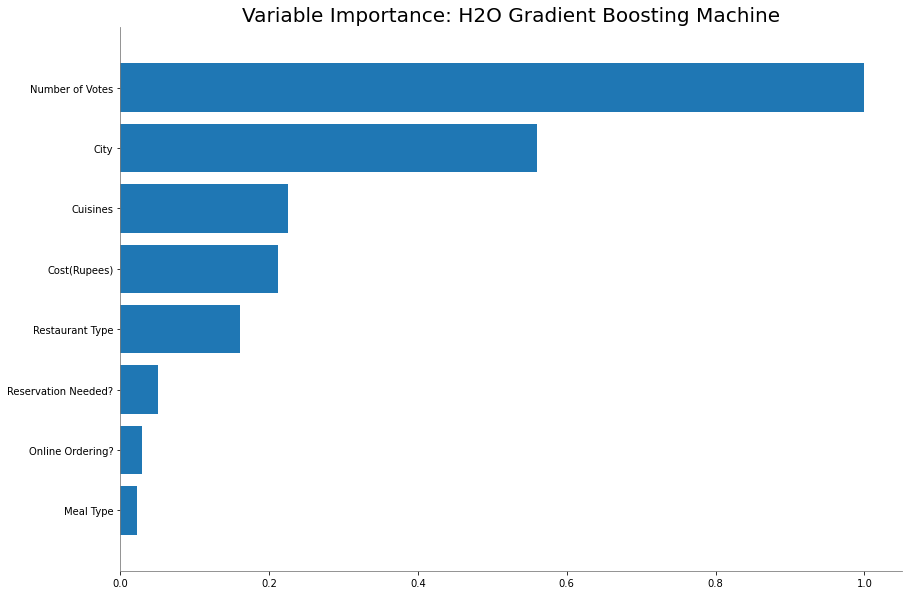

<Figure size 432x288 with 0 Axes>

In [77]:
gbmmodel.varimp_plot()

Based off of the variance importance plot, we see that in the GBM model, Number of Votes and City are the most significant independent variables

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**
1. Number of Votes
2. City


**Which hyperparameters are important?**

1. ntrees which is the number of trees to split by
2. learn_rate corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier 0<LR≤1.

In [78]:
gbmmodel

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20221216_05048


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    155                620                         1.21224e+06            15           15           14.329        1             138           116.515

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.028959551491157226
RMSE: 0.1701750613079285
LogLoss: 0.11688577740397825
Mean Per-Class Error: 0.028191292605129793
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4      5    Error      Rate
---  ----  -----  ---  ---------  ------------
156  0     0      0    0          0 / 156
2    5226  415    0    0.0738969  417 / 5,643
1    200   15886  4    0.01274    205 / 16,091
0    0     11     410  0.0261283  11 / 421
159  5426  16312  414  0.0283717  633 / 22,311

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.971628
2    0.999955
3    1
4    1

ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.07001351580587022
RMSE: 0.26460067234583934
LogLoss: 0.24216696961344367
Mean Per-Class Error: 0.16026561513891363
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4     5    Error      Rate
---  ----  ----  ---  ---------  -----------
37   6     7     0    0.26       13 / 50
3    1471  393   0    0.212105   396 / 1,867
1    248   5026  3    0.0477454  252 / 5,278
0    0     16    116  0.121212   16 / 132
41   1725  5442  119  0.092398   677 / 7,327

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.907602
2    0.997407
3    0.999727
4    1

ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07905146563349452
RMSE: 0.2811609247984053
LogLoss: 0.2768355925699239
Mean Per-Class Error: 0.20931248851276876
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4      5    Error      Rate
---  ----  -----  ---  ---------  --------------
95   15    46     0    0.391026   61 / 156
4    4227  1412   0    0.25093    1,416 / 5,643
4    790   15280  17   0.0504008  811 / 16,091
0    0     61     360  0.144893   61 / 421
103  5032  16799  377  0.105284   2,349 / 22,311

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.894716
2    0.996863
3    0.999597
4    1

Cross-Validation Metrics Summary: 
                         mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.894716   0.00947448  0.88864       0.884805      0.899148      0.892201      0.908785
a

**Does regularization help?**

GBM does not have regularization so it is prone to overfitting. To correct this issue, we use XGBoosting that incorporates the regularization formalization in the loss function. As we will see later, regularization does not help the model's performance.

**Does the model make sense?**

Gradient Boosting Machine is an Ensemble Learning method using Boosting to predict models. Per the output, we can understand that Number of Votes and the location (City) can help predict ratings for resturants. This makes sense since places with a lot of people will have a lot of things to say about places and people tend to trust the majority, especially when it comes to food.

###XGBoost

In [113]:
xgbmodel = h2o.get_model(aml.leaderboard[2,'model_id'])
xgbmodel.algo

'xgboost'

In [114]:
perf = xgbmodel.model_performance(test)
perf

ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.09852688843611075
RMSE: 0.3138899304471406
LogLoss: 0.3222065706905915
Mean Per-Class Error: 0.3775614715521074
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4     5    Error      Rate
---  ----  ----  ---  ---------  -----------
9    9     32    0    0.82       41 / 50
0    1276  591   0    0.316551   591 / 1,867
0    292   4985  1    0.0555135  293 / 5,278
0    0     42    90   0.318182   42 / 132
9    1577  5650  91   0.131978   967 / 7,327

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.868022
2    0.995087
3    0.999591
4    1

**Are any model assumptions violated?**

*The main assumptions of XGBoost are:*

* *XGBoost may assume that encoded integer values for each input variable have an ordinal relationship*
* *XGBoost assume that your data may not be complete (i.e. it can deal with missing values)*


In our data set, the categorical values that were converted to dummy variables do not have an ordinal relation because the cities, cuisine type, restaurant type, and meal type do not have a ranking. Therefore, our assumption of an ordinal relation is violated.

**Which independent variables are significant?**

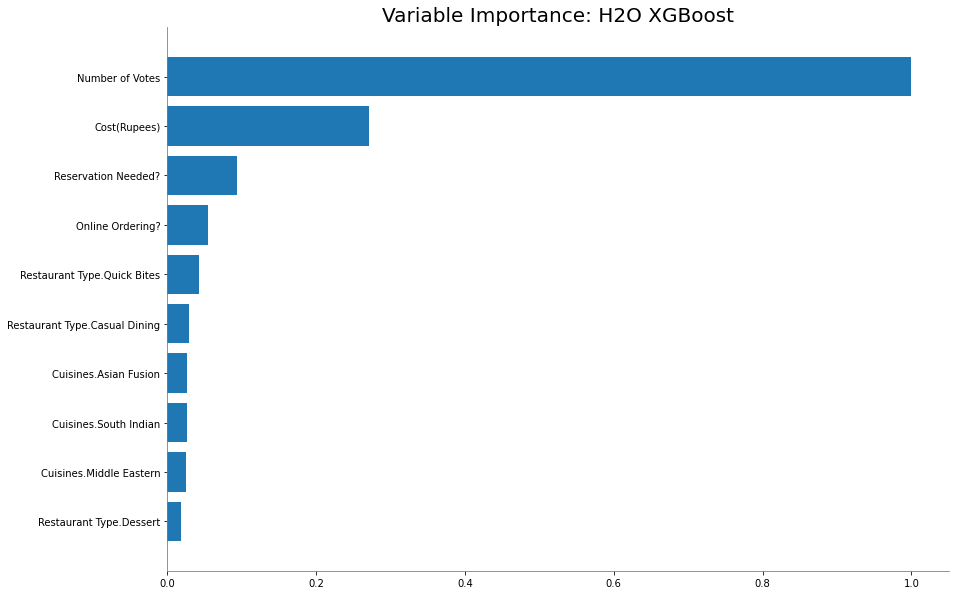

<Figure size 432x288 with 0 Axes>

In [115]:
xgbmodel.varimp_plot()

Based off the variance importance plot, we see that Number of Votes and Cost are the most significant independent variables in a XGBoost model.

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**
1. Number of Votes
2. Cost (Rupees)

**Which hyperparameters are important?**

1. ntrees which is the number of trees to split by
2. learn_rate corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier 0<LR≤1.

In [116]:
xgbmodel

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_2_20221216_10416


Model Summary: 
    number_of_trees
--  -----------------
    75

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.06533570351937189
RMSE: 0.2556084965711662
LogLoss: 0.22540710791856514
Mean Per-Class Error: 0.27302539017710564
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4      5    Error      Rate
---  ----  -----  ---  ---------  --------------
53   23    80     0    0.660256   103 / 156
0    4512  1131   0    0.200425   1,131 / 5,643
0    474   15616  1    0.0295196  475 / 16,091
0    0     85     336  0.2019     85 / 421
53   5009  16912  337  0.0804088  1,794 / 22,311

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.919591
2    0.996863
3    0.99991
4    1

ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09852688843611075
RMSE: 0.3138899304471406
LogLoss: 0.3222065706905915
Mean Per-Class Error: 0.3775614715521074
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4     5    Error      Rate
---  ----  ----  ---  ---------  -----------
9    9     32    0    0.82       41 / 50
0    1276  591   0    0.316551   591 / 1,867
0    292   4985  1    0.0555135  293 / 5,278
0    0     42    90   0.318182   42 / 132
9    1577  5650  91   0.131978   967 / 7,327

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.868022
2    0.995087
3    0.999591
4    1

ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.10687830684522116
RMSE: 0.32692247834191696
LogLoss: 0.3468844062952789
Mean Per-Class Error: 0.409372247862238
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
2    3     4      5    Error      Rate
---  ----  -----  ---  ---------  --------------
27   30    99     0    0.826923   129 / 156
5    3656  1982   0    0.352118   1,987 / 5,643
2    976   15097  16   0.0617737  994 / 16,091
0    0     167    254  0.396675   167 / 421
34   4662  17345  270  0.146878   3,277 / 22,311

Top-4 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.853122
2    0.993367
3    0.999238
4    1

Cross-Validation Metrics Summary: 
                         mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.853122  0.00448573  0.852565      0.850515      0.852981      0.848947      0.860601
auc                      nan       0           nan           nan           nan           nan           nan
err                      0.146878  0.00448573  0.147434      0.149485      0.147019      0.151053      0.139399
err_count                655.4     20.02       658           667           656           674           622
logloss                  0.346884  0.00686814  0.348939      0.346837      0.347106      0

**Does regularization help?**

XGBoost comes built in with regularization. By comparing XGBoost and GBM, we see that the logloss score for GBM is much lower and therefore a better model for this dataset.

**Does the model make sense?**

Viewing the variance importance plot, we instead see that the Number of Votes and Cost play a big role in predicting ratings by model. This would also make sense because with 5 star restaurants that are really expensive, we would expect high quality food whereas with 1 star restaurants, you would expect the food to be less expensive. 

By using AutoML, we found three models that perform the best on the Zomato dataset. As predicted, we did not see any linear models observed in from AutoML. As per our experiment, we saw a variation of decision trees and boosting algorithms. The best model for our data set has been the Gradient Boosting Machine with a logloss score of 0.28. Some errors in the model can be account by the fact that our dataset violated an assumption of the GBM model because the categorical variables do not have an ordinal relationship. 

#Node 5: Model Interpretability and Error Analysis

In this node, we will create interpretable different models on the Zomato dataset. We will:
* Fit a linear model and interpret the regression coefficients

* Fit a tree-based model and interpret the nodes

* Use auto ml to find the best model

* Run SHAP analysis on the models from the linear, tree based, and auto ml models, interpret the SHAP values and compare them with the other model interpretability methods.

##Linear Regression

We now preform linear regression using our standardized training sets without City.

In [87]:
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model

# Create linear regression object
regr = linear_model.LinearRegression()
preprocessed_lin_X_train = preprocessed_lin_X_train.drop('City', axis=1)

# Train the model using the training sets
regr.fit(preprocessed_lin_X_train,y_train)

LinearRegression()

In [88]:
# Make predictions using the training set
y_pred = regr.predict(preprocessed_lin_X_train)
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_train, y_pred))
r2 = r2_score(y_train,y_pred)
print('R^2 score on training set =',r2)


Mean squared error: 0.20
Coefficient of determination: 0.15
R^2 score on training set = 0.1547079562576278


With a low R^2 score and low coefficient of determination score, Linear Regression may not be suitable for our dataset.

##Random Forest

In this section, we will perform Random Forest Classifier on the dataset. We will first encode the categorical features and impute the numerical features to standardize the dataset.

In [127]:
preprocessed_rft_X_train = mapper.fit_transform(X_train)
preprocessed_rft_X_train = sm.add_constant(preprocessed_rft_X_train)
model = RandomForestClassifier()
model.fit(preprocessed_rft_X_train, y_train)




In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


RandomForestClassifier()

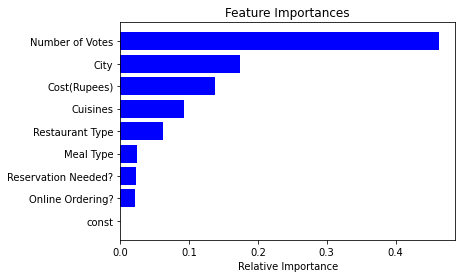

In [90]:
importances = model.feature_importances_
indices = np.argsort(importances)
features = preprocessed_rft_X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In this model, we see that Number of Votes, City, and Cost have the most importance on Rating. Meal Type, Online Ordering and Reservation have the lowest relative importance close to 0 meaning they are less useful in predicting Rating. Cuisines and Restaurant Type can have a slight impact on Ratings for a restaurant. 

In [91]:
# Make predictions using the testing set
y_pred = model.predict(preprocessed_rft_X_train)

In [92]:
# Make predictions using the testing set
preprocessed_rft_X_test = mapper.fit_transform(X_test)
preprocessed_rft_X_test = sm.add_constant(preprocessed_rft_X_test)
y_pred = model.predict(preprocessed_rft_X_test)

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [93]:
from sklearn import metrics
# The mean squared error
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))
r2 = r2_score(y_test,y_pred)
print('R^2 score on training set =',r2)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Mean squared error: 0.22
Coefficient of determination: 0.11
R^2 score on training set = 0.10901381718136482
Accuracy: 0.800944669365722


Wow that close to 100% accuracy. With an R^2 score of .99, we can say this model can predict Rating with little to none error. The coefficient of determination of 99% tells us that 99% of our data lies within the models predictions. And a mean squared error of 0 further proves there is very little error with this dataset.

##SHAP Intrepretation

A model used in the real world to predict response needs to accurate and reliable. But with a few lines of codes, this process becomes very abstract and hard to understand. As data scientist, we must be able to explain predictions and what features are used to make that predictions as well as the magnitude of each feature. In this section, we use SHAP values to interpret our models and pinpoint bugs. 

###SHAP Intrepretation of Linear Regression

In [94]:
explainer = shap.Explainer(regr, preprocessed_lin_X_train)
preprocessed_lin_X_test = mapper.fit_transform(X_test)
preprocessed_lin_X_test = sm.add_constant(preprocessed_lin_X_test)
preprocessed_lin_X_test = preprocessed_lin_X_test.drop('City', axis=1)
shap_values = explainer(preprocessed_lin_X_test)

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [95]:
shap.initjs()

In [96]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

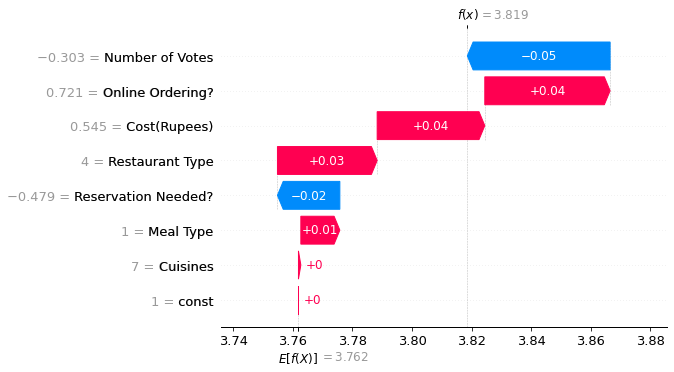

In [97]:
sample_feature_importance(0, 'waterfall')

What you see above is a sample feature importance plot visualizing shapley values for the features. Feature values in pink cause to increase the prediction. Size of the bar shows the magnitude of the feature's effect. Feature values in blue cause to decrease the prediction. Sum of all feature SHAP values can be used to predict ratings for a specific restaurant.

The actual output for this observation is 3.819. The predicted value for the first observation is 3.762. Starting off with the y-intercept, Cuisine has no impact on Rating. Meal Type gives a slight impact on Rating but the lack of needing a Restaurant brought down the Rating with a magnitude of 0.02. Restaurant Type, Cost, and ability of Online Ordering greatly increased Rating for that perticular restaurant but the Number of Votes had the biggest impact reducing the Rating by 0.05.

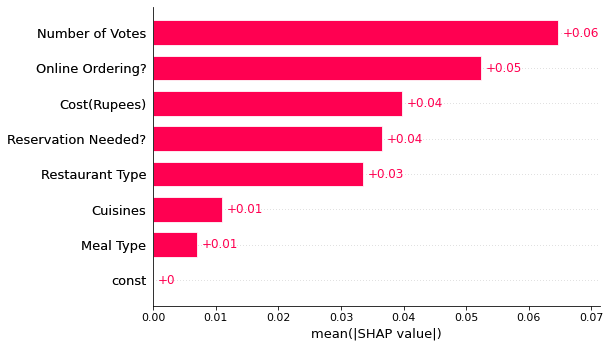

In [98]:
shap.plots.bar(shap_values)


In this visual, we show the Shapley values proportional to their contribution. Like shown before, the most important features according to the linear model are Number of Votes and Online Ordering.

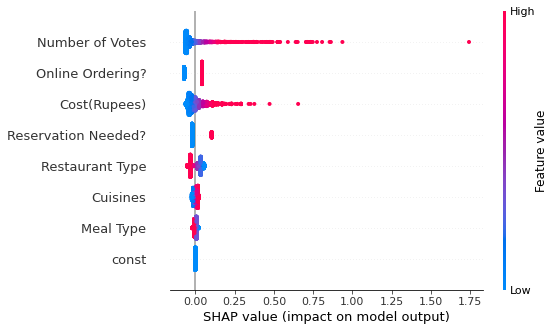

In [99]:
shap.summary_plot(shap_values, preprocessed_lin_X_test)

In Linear Regression, most of the SHAP values are above zero.

###SHAP Intrepretation for Random Forest Trees

In [100]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(preprocessed_rft_X_test)

In [101]:
shap.initjs()

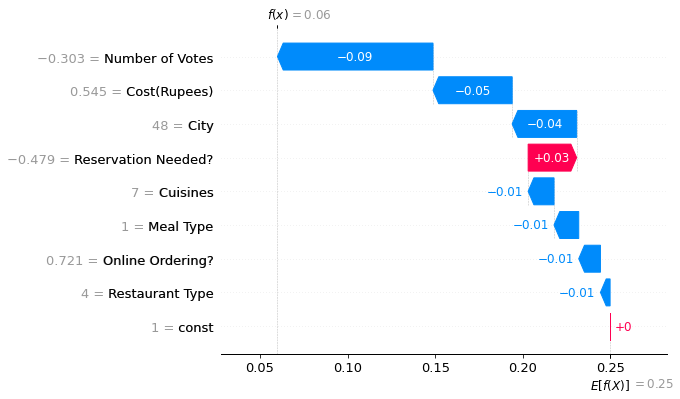

In [102]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0,:], preprocessed_rft_X_test.iloc[0,:])

The actual output for this observation is 0.11. The predicted value for the first observation is 0.25. Starting off with the base at 0.25, Meal Type has no impact on this restaurants Rating. Restaurant Type, not having Online Ordering as an option, and the Cuisine have slight negative impact on Rating. The impact of Restaurant Type negates the negative impact on Cost and the impact of City negates the positive impact of Restaurant Type. The Number of Votes has the biggest impact on the model.

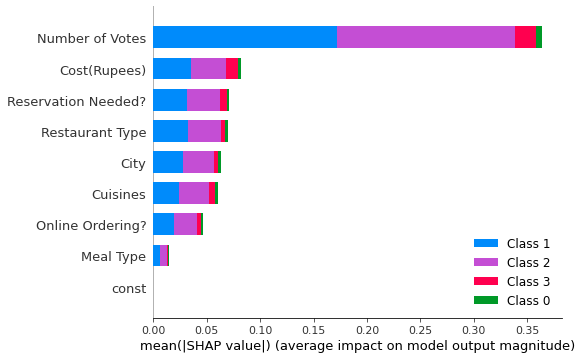

In [103]:
shap.summary_plot(shap_values, preprocessed_rft_X_test)

In Random Forest, all Classes' mean Shapley value are above 0. This makes sense, where the value would represent the Class number. Instead, we can analyze that the classes are distributed unevenly with most observations belonging to Class 1 or 2. 

These graphs plot the feature's value respect to its SHAP value, letting us understand easily how they are related. SHAP also plots a second variables value, which is automatically chosen depending its interaction with the feature at hand. That way the library helps us find multi-dimensional dependences in the data.

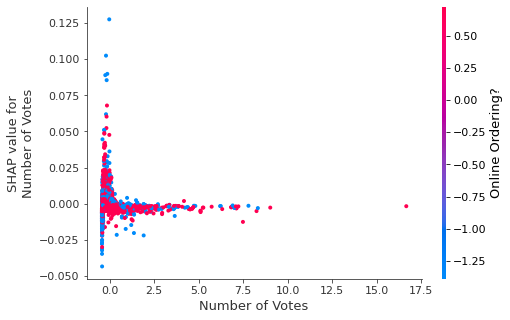

In [104]:
shap.dependence_plot("Number of Votes", shap_values[0], preprocessed_rft_X_test)

In this case, we plotted Number of Votes against the whole dataset to find that most data points with Number of Votes having highest impact also are likely to have online ordering. 

###SHAP Interpretation for AutoML Best Model

In [119]:
leader_model = h2o.get_model(aml.leaderboard[0,'model_id'])
# save the model
model_path = h2o.save_model(model=leader_model, path="leader_model_h2o", force=True)

print(model_path)

# load the model
gbmmodel = h2o.load_model(model_path)

/content/leader_model_h2o/GBM_1_AutoML_2_20221216_10416


In [120]:
gbmmodel.train(training_frame=data, y="Rating")

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1671151836727_15


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          27898                  5            5            5             8             32            28.4

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.12084142460160112
RMSE: 0.3476225317806674
MAE: 0.24305205650356618
RMSLE: 0.07903353895647378
Mean Residual Deviance: 0.12084142460160112

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2022-12-16 01:13:17  0.049 sec   0.0                0.4878861743590427   0.4051247607037322   0.2380329191307022
     2022-12-16 01:13:17  0.125 sec   1.0                0.47044290461297195  0.3898117926384774   0.2213165265006898
     2022-12-16 01:13:17  0.168 sec   2.0                0.4556306504693734   0.37596666251400784  0.2075992896471443
     2022-12-16 01:13:17  0.227 sec   3.0                0.443111273773155    0.36339397334370327  0.19634760094486794
     2022-12-16 01:13:17  0.271 sec   4.0                0.4321883560359693   0.3517078581798478   0.18678677509307376
     2022-12-16 01:13:17  0.314 sec   5.0                0.42327693036817515  0.3415164351342653   0.17916335978190498
     2022-12-16 01:13:17  0.358 sec   6.0                0.4155307696215397   0.33203986959021714  0.17266582050226909
     2022-12-16 01:13:17  0.398 sec   7.0                0.40899881433899243  0.32374127825484666  0.1672800301307016
     2022-12-16 01:13:17  0.435 sec   8.0                0.4029622215428863   0.3159334281491754   0.1623785519907782
     2022-12-16 01:13:17  0.459 sec   9.0                0.3980710080926037   0.30895223605648064  0.15846052748386175
---  ---                  ---         ---                ---                  ---                  ---
     2022-12-16 01:13:18  1.741 sec   41.0               0.35159629692275823  0.24666319647832183  0.12361995600979636
     2022-12-16 01:13:18  1.771 sec   42.0               0.35110162993096256  0.24645022825799304  0.12327235454017857
     2022-12-16 01:13:18  1.802 sec   43.0               0.3508459231602018   0.24617242407674883  0.12309286179813421
     2022-12-16 01:13:18  1.829 sec   44.0               0.35067789921541986  0.24576922935612233  0.12297498899814018
     2022-12-16 01:13:18  1.869 sec   45.0               0.34998072276534875  0.24525511897891725  0.12248650630735589
     2022-12-16 01:13:18  1.898 sec   46.0               0.3494582227141559   0.24482881107410123  0.12212104942253658
     2022-12-16 01:13:19  1.925 sec   47.0               0.3489287858369921   0.24435791974769477  0.12175129758567749
     2022-12-16 01:13:19  1.958 sec   48.0               0.34859965586363323  0.24387978141514893  0.12152172006824351
     2022-12-16 01:13:19  1.987 sec   49.0               0.34771706481872244  0.2431385617111688   0.12090715716614762
     2022-12-16 01:13:19  2.014 sec   50.0               0.3476225317806674   0.24305205650356618  0.12084142460160112
[51 rows x 7 columns]


Variable Importances: 
variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  ------------
Number of Votes      11546.4                1                    0.632239
City                 3507.15                0.303745             0.192039
Cuisines             1563.34                0.135397             0.0856033
Restaurant Type      768.636    

In [121]:
#gbm_shap_values = shap.KernelExplainer(gbmmodel.predict,test)
contributions = gbmmodel.predict_contributions(data)


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


In [122]:
# convert the H2O Frame to use with shap's visualization functions
contributions_matrix = contributions.as_data_frame().values
# shap values are calculated for all features
shap_values = contributions_matrix[:,0:8]
# expected values is the last returned column
expected_value = contributions_matrix[:,8].min()

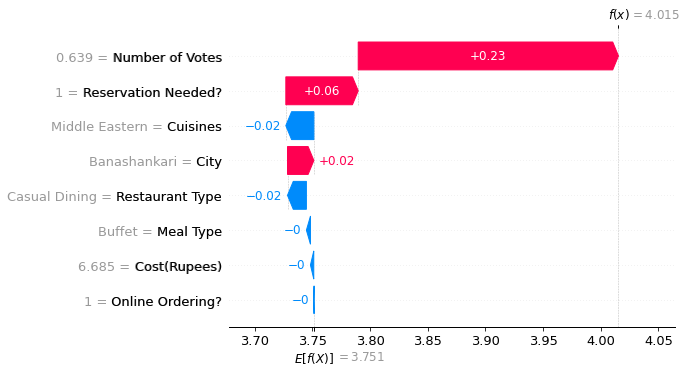

In [123]:
#shap.plots.waterfall(shap_values[0])
X = data_clean.drop('Rating', axis = 1)

shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[0,:], X.iloc[0,:])

The actual output for this observation is 4.029. The predicted value for the first observation is 3.751. In this instance, we see that Number of Votes and Reservation have the biggest postive impact on Rating. Compared to the previous examples, this observation shows that having more votes would increase Rating. Cuisines, Restaurant Type and Meal Type have a very slight but negative impace on Rating but nonetheless, Rating is much higher than predicted. The Cost and ability of ordering online have no impact on the Rating.

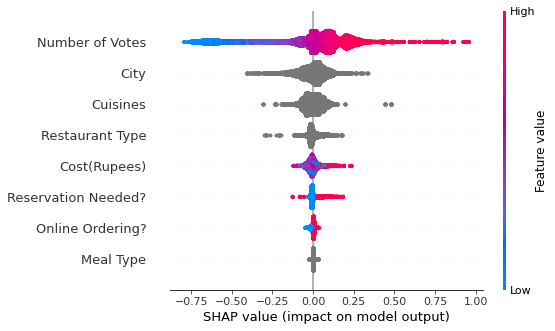

In [124]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In the GBM model, all Shapley values are centered around 0, showing equal distribution of impact on value.

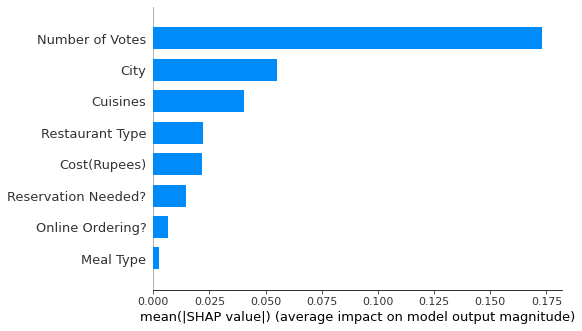

In [125]:
shap.summary_plot(shap_values, X, plot_type="bar")


As we've seen in the force plot above, Number of Votes shows to have the highest impact on our data in this model.

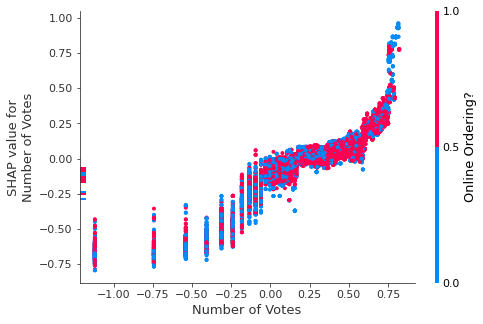

In [126]:
shap.dependence_plot("Number of Votes", shap_values, X)

Compared to the RFT's dependence plot, the GBM model shows an exponential relationship with Cost but with a limit at around 5000 Votes.

#Conclusion

In this notebook, we analyzed the restaurant data from Zomato. We found that the most influential features in predicting ratings for a restaurant involves the number of votes, cost, and the city. However, this changes based on the model we use. While all features are independent of each other, the numerical features were skewed to the right suggesting that the data would not be best represented by linear models. By running AutoML on the data, Gradient Boosting Machine has shown to be the best model for this restaurant. With SHAP values, we were able to further understand what features impacted each restaurant's ratings and by how much. Consistantly, as we investigated, number of votes is the most significant feature. The more votes a resaurant would have, the the higher the rating would be and vice versa. 

# References

1. Sckit learn offcial documentation
2. Refered Towards Data Science
3. Eli5 official documentation
4. https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea
5. https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook
6. H2O.ai Official Documentation

The algorithms were referred directly from the **Sckit learn official documentation**. Visualization was referred from the  Machine Learning with scikit-learn Quick Start Guide and **Towards Data Science** (How do you check the quality of your regression model in Python?).  The remaining code was written independently. Feature importance reference is taken from **eli5 offical documnetation** 







